# Coffee Outlet Study in Winston Salem NC

This notebook is a study to analyze the best places to open a coffee outlet in the Winston Salem area



Method:
1. Gather data on competing coffee shops in the area
1.1. Obtain list of Zipcodes within 20 miles of center of Winston Salem NC
1.2. Get Longitute and Latitude of each of the zipcodes
1.3.  Call Foursquare API to pull closest coffee shops to each of these zipcodes
1.4.  Remove duplicate coffee shop IDs
2. Obtain ZCTA boundaries for the area
2.1. Load GeoJSON for all ZCTAs in North Carolina
2.2. Filter by the list of Zipcodes within 20 mile radius (note: ZCTAs are approximately the same as zipcodes)
2.3. Create GeoJSON file for ZCTAs in the area
3. Choropleth map of coffee shops 
3.1. Map each ZCTA with color according to number of coffee shops per ZCTA
3.2. add circles at Longitude and Latitude for each coffee shop venue found from Foursquare 
4. create data for additional maps
4.1. Add count of Starbucks, Dunkin' and other coffee shops per ZCTA
4.2. add Census population data per ZCTA
4.3. add Census Household count and mean income data per ZCTA
5. Plot these maps
6. plot comparison of various features to see if and how they correlate

In [1]:
#imports
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes 
#from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans



print('Libraries imported.')


Libraries imported.


In [2]:
# install folium
#!conda install -c conda-forge folium=0.11.0  --yes 
#note: above was done in command line using conda install -c conda-forge folium and conda update
import folium # map rendering library
print('Libraries imported.')

Libraries imported.


# 1 Get Foursquare data


In [3]:
# define function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [4]:
#read the zipcodes within 20 miles of the Longitude and Latitude of Winston Salem NC
# note:this data was pulled from this page
#https://www.freemaptools.com/find-zip-codes-inside-radius.htm
# Longitude and Latitude of Winston Salem NC 36.1334,-80.2774 and 20 mile radius 
wszips = pd.read_csv('zipsWithin20MilesOfWinstonSalemNC.csv')
print(wszips.shape)
wszips.head()

(67, 6)


,zipcode,state,county,city,timezone,distance
0,27155,NC,Forsyth,Winston Salem,5,1
1,27152,NC,Forsyth,Winston Salem,5,1
2,27150,NC,Forsyth,Winston Salem,5,1
3,27157,NC,Forsyth,Winston Salem,5,1
4,27101,NC,Forsyth,Winston Salem,5,2


In [5]:
#read the zipcodes from North Carolina that provide the Longitude and Latitude of each zipcode
# note:this data was pulled from this page
#https://public.opendatasoft.com/explore/dataset/us-zip-code-latitude-and-longitude/table/
#For NC only
#https://public.opendatasoft.com/explore/dataset/us-zip-code-latitude-and-longitude/export/?refine.state=NC
ziplonglat = pd.read_csv('us-zip-code-latitude-and-longitude.csv', delimiter=';')
print (ziplonglat.shape)
ziplonglat.head()

(1112, 8)


,Zip,City,State,Latitude,Longitude,Timezone,Daylight savings time flag,geopoint
0,28668,Roaring Gap,NC,36.388460,-81.00733,-5,1,"36.38846,-81.00733"
1,28786,Waynesville,NC,35.511094,-82.99607,-5,1,"35.511094,-82.99607"
2,28607,Boone,NC,36.212770,-81.66255,-5,1,"36.21277,-81.66255"
3,28345,Hamlet,NC,34.879186,-79.69001,-5,1,"34.879186,-79.69001"
4,28463,Tabor City,NC,34.124830,-78.82187,-5,1,"34.12483,-78.82187"


In [6]:
#now merge these two by zipcode
wszipsLongLat = wszips.merge(ziplonglat,left_on="zipcode", right_on="Zip")
print(wszipsLongLat.shape)
wszipsLongLat.head()

(65, 14)


,zipcode,state,county,city,timezone,distance,Zip,City,State,Latitude,Longitude,Timezone,Daylight savings time flag,geopoint
0,27155,NC,Forsyth,Winston Salem,5,1,27155,Winston Salem,NC,36.027482,-80.20728,-5,1,"36.027482,-80.20728"
1,27152,NC,Forsyth,Winston Salem,5,1,27152,Winston Salem,NC,36.027482,-80.20728,-5,1,"36.027482,-80.20728"
2,27150,NC,Forsyth,Winston Salem,5,1,27150,Winston Salem,NC,36.027482,-80.20728,-5,1,"36.027482,-80.20728"
3,27157,NC,Forsyth,Winston Salem,5,1,27157,Winston Salem,NC,36.027482,-80.20728,-5,1,"36.027482,-80.20728"
4,27101,NC,Forsyth,Winston Salem,5,2,27101,Winston Salem,NC,36.107037,-80.21918,-5,1,"36.107037,-80.21918"


In [7]:
print("No.of.unique values in each column :\n", 
      wszipsLongLat.nunique(axis=0) )
print()
print("unique counties:\n", wszipsLongLat. county.unique())

No.of.unique values in each column :
 zipcode                       65
state                          1
county                         6
city                          26
timezone                       1
distance                      23
Zip                           65
City                          26
State                          1
Latitude                      41
Longitude                     41
Timezone                       1
Daylight savings time flag     1
geopoint                      41
dtype: int64

unique counties:
 ['Forsyth' 'Davidson' 'Guilford' 'Stokes' 'Davie' 'Yadkin']


In [8]:
#drop columns
wszipsLongLat = wszipsLongLat.drop(['zipcode','county','city','timezone','distance','state','City','State','Timezone','Daylight savings time flag','geopoint'], axis=1)

#drop repeated long&Lat
wszipsLongLat = wszipsLongLat.drop_duplicates(subset=['Latitude', 'Longitude'], keep='first')

wszipsLongLat=wszipsLongLat.reset_index()
print(wszipsLongLat.shape)
wszipsLongLat.head()


(41, 4)


,index,Zip,Latitude,Longitude
0,0,27155,36.027482,-80.207280
1,4,27101,36.107037,-80.219180
2,7,27102,36.032304,-80.396168
3,18,27109,36.133577,-80.276800
4,19,27105,36.147887,-80.234230


In [9]:
# define function that gets all venues in a given zipcode
def get_venues(row):
    ziplongitude = row['Longitude']
    ziplatitude  = row['Latitude']
    thiszipcode = row['Zip']
    print('get_venues: ziplongitude=',ziplongitude,'ziplatitude=',ziplatitude,'thiszipcode=',thiszipcode )
    CLIENT_ID = 'HAV2NCO1YXWNELAALLJOTPMERDCZQDOBLTWXZ25Q4O54KDG1' # your Foursquare ID
    CLIENT_SECRET = 'HTE54IXTNBTJNGDUSSC0PAI0ZVOB3BEJYYRV3N4V0YTC0LNT' # your Foursquare Secret
    VERSION = '20201224' # Foursquare API version
    radius = 32190 # define radius in meters. 32,190 is about 20 miles
    LIMIT = 500 # A default Foursquare API limit value - Limit is 50 per page
    llAcc = 10 # Long/Lat accuracy in meters
    #category = '4bf58dd8d48988d1e0931735,5e18993feee47d000759b256'
    #category = '5e18993feee47d000759b256'  #coffee roaster
    category = '4bf58dd8d48988d1e0931735'  #coffee shop
    url = 'https://api.foursquare.com/v2/venues/search?&v={}&ll={},{}&categoryId={}&llAcc={}&client_id={}&client_secret={}&radius={}&limit={}'.format(
        VERSION, 
        ziplatitude, 
        ziplongitude, 
        category,
        llAcc,
        CLIENT_ID, 
        CLIENT_SECRET, 
        radius, 
        LIMIT)
    print("URL:\n",url)
    results = requests.get(url).json()
    #print (results)
    #clean the json and structure it into a pandas dataframe.
    venues = results['response']['venues']
    #print ('venues =',venues)    
    nearby_venues = json_normalize(venues) # flatten JSON
    #print ('nearby venues =',nearby_venues) 
    #print ('before filter colms\n",nearby_venues.head())
    #print("No.of.unique values in each column :\n", nearby_venues.nunique(axis=0) )
    #print("Shape :\n", nearby_venues.shape)
    # filter columns
    filtered_columns = ['name', 'categories', 'location.postalCode','location.lat','location.lng','id']
    #print('nearby_venues\n',nearby_venues.head())
    nearby_venues =nearby_venues.loc[:, filtered_columns]
    #print(nearby_venues.head())
    # filter the category for each row
    nearby_venues['venue.catname'] = nearby_venues.apply(get_category_type, axis=1)

    nearby_venues.pop('categories') #remove the categories array from each row

    # clean column names
    nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]  #take the . out of column names

    print ("nearby_venues shape =",nearby_venues.shape)
    #print (nearby_venues.head())
    
  
    return nearby_venues


In [10]:
#create an empty dataframe
wcvenues = pd.DataFrame(columns=['name', 'postalCode', 'lat','lng','catname','id'])
# iterate through rows
#https://pythonexamples.org/pandas-dataframe-iterate-rows-iterrows/
for index, row in wszipsLongLat.iterrows():
    print( row['Zip'], 'has longitude=', row['Longitude'], 'and Latitude=',row['Latitude'] )
    #now for each zipcode we need to call the Foursquare API and add the data to the dataframe of venues
    wcvenues = wcvenues.append(get_venues(row),ignore_index = True)
    print ("wcvenues shape =",wcvenues.shape)
    #wcvenues=wcvenues.reset_index()
print ("pulled data for all listed zipcodes")

27155.0 has longitude= -80.20728 and Latitude= 36.027482
get_venues: ziplongitude= -80.20728 ziplatitude= 36.027482 thiszipcode= 27155.0
URL:
 https://api.foursquare.com/v2/venues/search?&v=20201224&ll=36.027482,-80.20728&categoryId=4bf58dd8d48988d1e0931735&llAcc=10&client_id=HAV2NCO1YXWNELAALLJOTPMERDCZQDOBLTWXZ25Q4O54KDG1&client_secret=HTE54IXTNBTJNGDUSSC0PAI0ZVOB3BEJYYRV3N4V0YTC0LNT&radius=32190&limit=500


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


nearby_venues shape = (50, 6)
wcvenues shape = (50, 6)
27101.0 has longitude= -80.21918 and Latitude= 36.107037
get_venues: ziplongitude= -80.21918 ziplatitude= 36.107037 thiszipcode= 27101.0
URL:
 https://api.foursquare.com/v2/venues/search?&v=20201224&ll=36.107037,-80.21918&categoryId=4bf58dd8d48988d1e0931735&llAcc=10&client_id=HAV2NCO1YXWNELAALLJOTPMERDCZQDOBLTWXZ25Q4O54KDG1&client_secret=HTE54IXTNBTJNGDUSSC0PAI0ZVOB3BEJYYRV3N4V0YTC0LNT&radius=32190&limit=500
nearby_venues shape = (50, 6)
wcvenues shape = (100, 6)
27102.0 has longitude= -80.396168 and Latitude= 36.032304
get_venues: ziplongitude= -80.396168 ziplatitude= 36.032304 thiszipcode= 27102.0
URL:
 https://api.foursquare.com/v2/venues/search?&v=20201224&ll=36.032304,-80.396168&categoryId=4bf58dd8d48988d1e0931735&llAcc=10&client_id=HAV2NCO1YXWNELAALLJOTPMERDCZQDOBLTWXZ25Q4O54KDG1&client_secret=HTE54IXTNBTJNGDUSSC0PAI0ZVOB3BEJYYRV3N4V0YTC0LNT&radius=32190&limit=500
nearby_venues shape = (47, 6)
wcvenues shape = (147, 6)
27109.

nearby_venues shape = (49, 6)
wcvenues shape = (934, 6)
27012.0 has longitude= -80.39312 and Latitude= 36.027101
get_venues: ziplongitude= -80.39312 ziplatitude= 36.027101 thiszipcode= 27012.0
URL:
 https://api.foursquare.com/v2/venues/search?&v=20201224&ll=36.027101,-80.39312&categoryId=4bf58dd8d48988d1e0931735&llAcc=10&client_id=HAV2NCO1YXWNELAALLJOTPMERDCZQDOBLTWXZ25Q4O54KDG1&client_secret=HTE54IXTNBTJNGDUSSC0PAI0ZVOB3BEJYYRV3N4V0YTC0LNT&radius=32190&limit=500
nearby_venues shape = (47, 6)
wcvenues shape = (981, 6)
27310.0 has longitude= -79.9842 and Latitude= 36.178137
get_venues: ziplongitude= -79.9842 ziplatitude= 36.178137 thiszipcode= 27310.0
URL:
 https://api.foursquare.com/v2/venues/search?&v=20201224&ll=36.178137,-79.9842&categoryId=4bf58dd8d48988d1e0931735&llAcc=10&client_id=HAV2NCO1YXWNELAALLJOTPMERDCZQDOBLTWXZ25Q4O54KDG1&client_secret=HTE54IXTNBTJNGDUSSC0PAI0ZVOB3BEJYYRV3N4V0YTC0LNT&radius=32190&limit=500
nearby_venues shape = (50, 6)
wcvenues shape = (1031, 6)
27262.0 ha

nearby_venues shape = (49, 6)
wcvenues shape = (1819, 6)
27042.0 has longitude= -80.05135 and Latitude= 36.335676
get_venues: ziplongitude= -80.05135 ziplatitude= 36.335676 thiszipcode= 27042.0
URL:
 https://api.foursquare.com/v2/venues/search?&v=20201224&ll=36.335676,-80.05135&categoryId=4bf58dd8d48988d1e0931735&llAcc=10&client_id=HAV2NCO1YXWNELAALLJOTPMERDCZQDOBLTWXZ25Q4O54KDG1&client_secret=HTE54IXTNBTJNGDUSSC0PAI0ZVOB3BEJYYRV3N4V0YTC0LNT&radius=32190&limit=500
nearby_venues shape = (50, 6)
wcvenues shape = (1869, 6)
27263.0 has longitude= -79.96062 and Latitude= 35.914548
get_venues: ziplongitude= -79.96062 ziplatitude= 35.914548 thiszipcode= 27263.0
URL:
 https://api.foursquare.com/v2/venues/search?&v=20201224&ll=35.914548,-79.96062&categoryId=4bf58dd8d48988d1e0931735&llAcc=10&client_id=HAV2NCO1YXWNELAALLJOTPMERDCZQDOBLTWXZ25Q4O54KDG1&client_secret=HTE54IXTNBTJNGDUSSC0PAI0ZVOB3BEJYYRV3N4V0YTC0LNT&radius=32190&limit=500
nearby_venues shape = (50, 6)
wcvenues shape = (1919, 6)
27407

In [11]:
#drop repeated long&Lat
wcvenues = wcvenues.drop_duplicates(subset=['id'], keep='first')

wcvenues=wcvenues.reset_index()



In [12]:
print(wcvenues.shape)
print (wcvenues['name'].value_counts())
#print (wcvenues['postalCode'].value_counts())
wcvenues.head()
# we see that most frequent coffee shops are Starbucks, Dunkin', and Sheetz


(112, 7)
Starbucks                               34
Dunkin'                                 13
Sheetz                                   3
Krispy Kreme Doughnuts                   2
Barnes & Noble                           2
Green Bean                               1
Wisteria                                 1
FosterHobbs Coffee Roasters              1
KrabzKoffeeMess                          1
The Good Life Cafe                       1
Union Coffee                             1
Bruegger's                               1
Oma's Chocolate Factory & Coffee         1
Green Joe's Coffee Company               1
Coffee Central                           1
The Coffee Mill in Lewisville            1
Camino Bakery                            1
Corners                                  1
Starbucks -- Town Of Tioga               1
Krankies Coffee                          1
Chat And Chew                            1
Washington Perk & Provision Company      1
Rena Marie's Coffees                     1
Vi

,index,name,postalCode,lat,lng,catname,id
0,0,Starbucks,27410,36.088837,-79.885755,Coffee Shop,4b3ade2ff964a5205e6f25e3
1,1,Starbucks,27105,36.187902,-80.276827,Coffee Shop,4bd2fcd1462cb7137340dd07
2,2,Starbucks,27103,36.070964,-80.338865,Coffee Shop,4b807884f964a520667530e3
3,3,Starbucks,27103,36.084073,-80.294855,Coffee Shop,561bab06498e228017f7cc09
4,4,Starbucks,27012,36.022563,-80.381500,Coffee Shop,4b362cecf964a520c33025e3


In [13]:
# now, let's see what the counts are per zipcode

wcvenues['postalCode'].value_counts()

27103    10
27408     9
27101     9
27407     7
27410     6
27106     5
27284     5
27215     4
27030     3
28144     3
27021     3
27405     3
27262     3
27012     3
27023     2
27403     2
27455     2
28147     2
27409     2
27401     2
27263     2
27104     2
27260     1
28138     1
27052     1
28023     1
27041     1
27282     1
27110     1
27295     1
27051     1
27265     1
27105     1
27358     1
27370     1
27406     1
28137     1
27127     1
Name: postalCode, dtype: int64

In [14]:
# #wcvenues.pivot_table(index='postalCode', columns='name')
# print (wcvenues.tail())
# print (wcvenues['name'].value_counts())
wcvenues2= wcvenues
# print(wcvenues2.head())
# print (wcvenues2['name'].value_counts())

In [15]:
print (wcvenues2['name'].value_counts())
wcvenues2.loc[(wcvenues2['name']!='Starbucks') & (wcvenues2['name'] != "Dunkin'") ,'name'] = 'Other'
print()
print (wcvenues2['name'].value_counts())


Starbucks                               34
Dunkin'                                 13
Sheetz                                   3
Krispy Kreme Doughnuts                   2
Barnes & Noble                           2
Green Bean                               1
Wisteria                                 1
FosterHobbs Coffee Roasters              1
KrabzKoffeeMess                          1
The Good Life Cafe                       1
Union Coffee                             1
Bruegger's                               1
Oma's Chocolate Factory & Coffee         1
Green Joe's Coffee Company               1
Coffee Central                           1
The Coffee Mill in Lewisville            1
Camino Bakery                            1
Corners                                  1
Starbucks -- Town Of Tioga               1
Krankies Coffee                          1
Chat And Chew                            1
Washington Perk & Provision Company      1
Rena Marie's Coffees                     1
Village Exp


And now to create a Choropleth map, we will use the choropleth method with the following main parameters:

geo_data, which is the GeoJSON file.

data, which is the dataframe containing the data.

columns, which represents the columns in the dataframe that will be used to create the Choropleth map.

key_on, which is the key or variable in the GeoJSON file that contains the name of the variable of interest. To determine that, you will need to open the GeoJSON file using any text editor and note the name of the key or variable that contains the name of the countries, since the countries are our variable of interest. In this case, name is the key in the GeoJSON file that contains the name of the countries. Note that this key is case_sensitive, so you need to pass exactly as it exists in the GeoJSON file.

In [16]:
#using this: https://stackoverflow.com/questions/47136436/python-pandas-convert-value-counts-output-to-dataframe
wszips= wcvenues['postalCode']
wszips = wszips.value_counts().rename_axis('ZCTA5CE10').to_frame('count')
wszips.reset_index(level=0, inplace=True)
wszips.head()

,ZCTA5CE10,count
0,27103,10
1,27408,9
2,27101,9
3,27407,7
4,27410,6


### Filter GeoJSON ZCTA by zips within 20 mile radius of Winston-Salem, NC
This code is to pull in GEOJSON for all ZCTAs (ZipCode Tabulation Areas) in US and filter it to only include geography boundaries for ZCTAs within 20 miles of Winston-Salem, NC

In [17]:
#read the zipcodes within 20 miles of the Longitude and Latitude of Winston Salem NC
# note:this data was pulled from this page
#https://www.freemaptools.com/find-zip-codes-inside-radius.htm
# Longitude and Latitude of Winston Salem NC 36.1334,-80.2774 and 20 mile radius 
wszctas = pd.read_csv('zipsWithin20MilesOfWinstonSalemNC.csv')
print(wszctas.shape)
wszctas.head()

(67, 6)


,zipcode,state,county,city,timezone,distance
0,27155,NC,Forsyth,Winston Salem,5,1
1,27152,NC,Forsyth,Winston Salem,5,1
2,27150,NC,Forsyth,Winston Salem,5,1
3,27157,NC,Forsyth,Winston Salem,5,1
4,27101,NC,Forsyth,Winston Salem,5,2


In [18]:
#convert zips to string
wszctas = wszctas.astype('str') 

In [19]:

print ("wszctas type", type(wszctas['zipcode'][15]))
wszctas

wszctas type <class 'str'>


,zipcode,state,county,city,timezone,distance
0,27155,NC,Forsyth,Winston Salem,5,1
1,27152,NC,Forsyth,Winston Salem,5,1
2,27150,NC,Forsyth,Winston Salem,5,1
3,27157,NC,Forsyth,Winston Salem,5,1
4,27101,NC,Forsyth,Winston Salem,5,2
5,27110,NC,Forsyth,Winston Salem,5,2
6,27120,NC,Forsyth,Winston Salem,5,4
7,27102,NC,Forsyth,Winston Salem,5,4
8,27113,NC,Forsyth,Winston Salem,5,4
9,27117,NC,Forsyth,Winston Salem,5,4


In [20]:
# with the help of this post:
# https://towardsdatascience.com/visualizing-data-at-the-zip-code-level-with-folium-d07ac983db20
# and this ZCTA data from every state in USA
# https://github.com/uscensusbureau/citysdk/blob/master/v2/GeoJSON/500k/2019/zip-code-tabulation-area.json
# load GeoJSON
with open ('zip-code-tabulation-area-Censusgithub.json', 'r') as jsonFile:
        data = json.load(jsonFile)
tmp=data
#remove ZIP codes not in our dataset
geozips = []
matches=0
for i in range(len(tmp['features'])):
    thisone= (tmp['features'][i]['properties']['ZCTA5CE10'] )
    #print ("value=",thisone, " type", type(thisone))
    #print ("wszctas type", type(wszctas['zipcodes'][0]))
    if thisone in list(wszctas['zipcode']):
        #print("match")
        geozips.append(tmp['features'][i])
        matches+=1

#print("\ngeozips:",geozips)
print("matches=",matches)

matches= 36


In [21]:
#creating new JSON object
new_json = dict.fromkeys('type','features')
new_json['type'] = 'FeatureCollection'
new_json['features'] = geozips

#print("\nnew_json.shape:",new_json.shape)
#save JSON object as updated file
open("updated-GeoJSON",'w').write(
    json.dumps(new_json, sort_keys=True,indent=4, separators=(',',': '))
)

599368

In [22]:
#get the GeoJSON
#nc_zips = f"https://raw.githubusercontent.com/OpenDataDE/State-zip-code-GeoJSON/master/nc_north_carolina_zip_codes_geo.min.json"
nc_zips = f"updated-GeoJSON"

In [23]:
# create a map

ws_map = folium.Map(location=[36.11,-80.23], zoom_start=10)


In [24]:
# generate choropleth map using the count per ZCTA
#


ws_map.choropleth(
    geo_data=nc_zips,
    key_on='feature.properties.ZCTA5CE10',
    data=wszips,
    columns=['ZCTA5CE10','count'],
    fill_color='YlOrRd',
     nan_fill_color='black',
     nan_fill_opacity=0.1,
     line_opacity=0.9,
    fill_opacity=0.5,
    legend_name="Winston Salem NC Coffee Shops per ZCTA"
)

ws_map


C:\ProgramData\Anaconda3\lib\site-packages\folium\folium.py:413: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [25]:
#ws_map

In [26]:
# instantiate a feature group for the venues in the dataframe
venues = folium.map.FeatureGroup()

# loop through the coffee shops and add each to the feature group
for lat, lng, name in zip(wcvenues.lat, wcvenues.lng, wcvenues.name):
    venues.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=5,  # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color= 'orange' if name=="Dunkin'" else 'blue' if name=='Starbucks' else 'green',
            fill_opacity=0.6
        )
    )

# add venues to map
ws_map.add_child(venues)
ws_map

In [27]:
wszipssort= wszips.sort_values(by = 'ZCTA5CE10') 
wszipssort.head()


,ZCTA5CE10,count
13,27012,3
10,27021,3
14,27023,2
8,27030,3
26,27041,1


In [28]:
wszips.head()

,ZCTA5CE10,count
0,27103,10
1,27408,9
2,27101,9
3,27407,7
4,27410,6


In [29]:
population = pd.read_csv('population.csv')
population

,ZCTA,Num_Households,Income,Population
0,27012,10792,101423,28334
1,27018,3150,63747,8204
2,27021,7396,65862,17489
3,27023,5159,112704,12728
4,27028,10163,64194,26465
5,27030,15179,56738,35575
6,27051,3064,57328,7641
7,27101,8631,58088,19713
8,27103,15605,67826,34688
9,27104,12779,110651,28402


In [30]:

wcvenues2.sort_values(by='postalCode')


,index,name,postalCode,lat,lng,catname,id
38,38,Dunkin',27012,36.036979,-80.385050,Donut Shop,4c59b8e104f9be9aa905f060
33,33,Other,27012,36.031778,-80.383565,Donut Shop,5603249f498e87787ee37b8c
4,4,Starbucks,27012,36.022563,-80.381500,Coffee Shop,4b362cecf964a520c33025e3
63,129,Other,27021,36.264740,-80.360008,Coffee Shop,4fea0900e4b010a677afabae
71,139,Other,27021,36.270321,-80.360893,Coffee Shop,5e6fd7f61b0bc80008995798
7,7,Other,27021,36.278390,-80.340364,Gas Station,4eeb87b1754a75f702299575
62,128,Other,27023,36.090866,-80.379948,Coffee Shop,4fb7073be4b0c776a682d270
20,20,Other,27023,36.100331,-80.414143,Coffee Shop,4bec4b3749430f477e8b07d2
102,1255,Other,27030,36.501524,-80.607839,Coffee Shop,4f323ac919836c91c7c2f19d
95,1114,Starbucks,27030,36.480035,-80.616393,Coffee Shop,59f30fe0872f7d6975905901


In [31]:
#pivot https://towardsdatascience.com/pandas-pivot-the-ultimate-guide-5c693e0771f3
newdf=wcvenues2.pivot_table(index = "postalCode",  columns="name", aggfunc='count', values="id", fill_value=0)
newdf.head()


name,Dunkin',Other,Starbucks
postalCode,,,
27012,1,1,1
27021,0,3,0
27023,0,2,0
27030,0,2,1
27041,0,1,0


In [32]:
#add to the wszips table for each zcta: the number of Starbucks,Dunkin, Other, population, household count, household income
# this will be done with a merge
wszips2 = wszips.merge(newdf,left_on="ZCTA5CE10", right_on="postalCode")
wszips2.head()

,ZCTA5CE10,count,Dunkin',Other,Starbucks
0,27103,10,1,4,5
1,27408,9,1,6,2
2,27101,9,0,9,0
3,27407,7,2,2,3
4,27410,6,0,0,6


In [33]:
population.dtypes

ZCTA              int64
Num_Households    int64
Income            int64
Population        int64
dtype: object

In [34]:
population['ZCTA']=population['ZCTA'].astype(str)
population.dtypes

ZCTA              object
Num_Households     int64
Income             int64
Population         int64
dtype: object

In [35]:
wszips3 = wszips2.merge(population,left_on="ZCTA5CE10", right_on="ZCTA")
wszips3.head()

,ZCTA5CE10,count,Dunkin',Other,Starbucks,ZCTA,Num_Households,Income,Population
0,27103,10,1,4,5,27103,15605,67826,34688
1,27408,9,1,6,2,27408,8114,118276,18323
2,27101,9,0,9,0,27101,8631,58088,19713
3,27407,7,2,2,3,27407,20264,65421,51900
4,27410,6,0,0,6,27410,24560,91063,55707


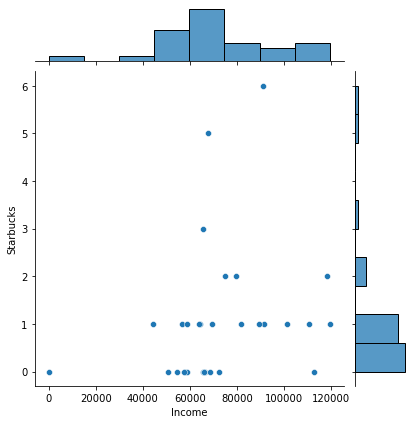

In [36]:
#!pip install seaborn
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plot = sns.jointplot(x='Income',y='Starbucks', data=wszips3)

In [37]:
wszips3['income_NumH'] = wszips3.Income * wszips3.Num_Households
wszips3.head()

,ZCTA5CE10,count,Dunkin',Other,Starbucks,ZCTA,Num_Households,Income,Population,income_NumH
0,27103,10,1,4,5,27103,15605,67826,34688,1058424730
1,27408,9,1,6,2,27408,8114,118276,18323,959691464
2,27101,9,0,9,0,27101,8631,58088,19713,501357528
3,27407,7,2,2,3,27407,20264,65421,51900,1325691144
4,27410,6,0,0,6,27410,24560,91063,55707,2236507280


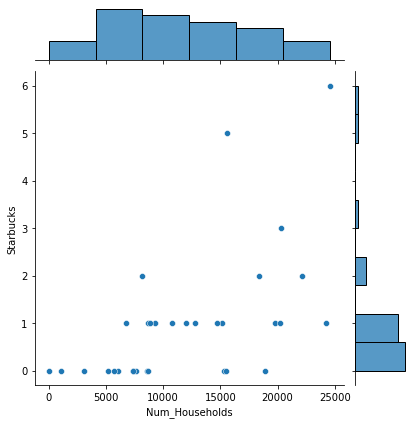

In [38]:
plot = sns.jointplot(x='Num_Households',y='Starbucks', data=wszips3)

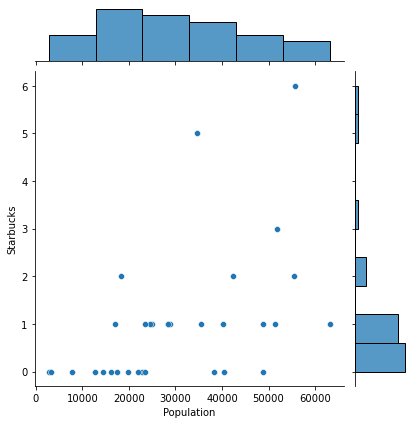

In [39]:
plot = sns.jointplot(x='Population',y='Starbucks', data=wszips3)

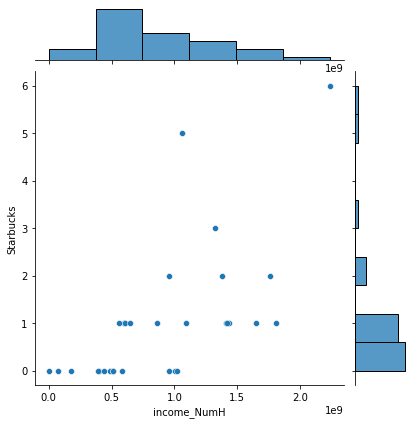

In [40]:
plot = sns.jointplot(x='income_NumH',y='Starbucks', data=wszips3)

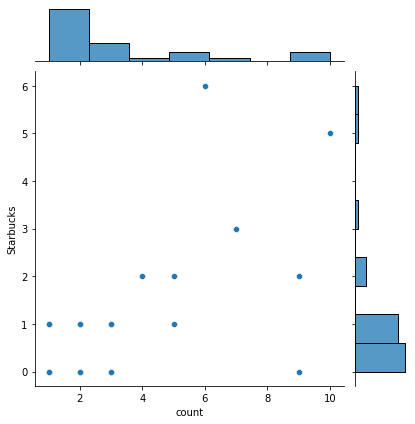

In [41]:
plot = sns.jointplot(x='count',y='Starbucks', data=wszips3)

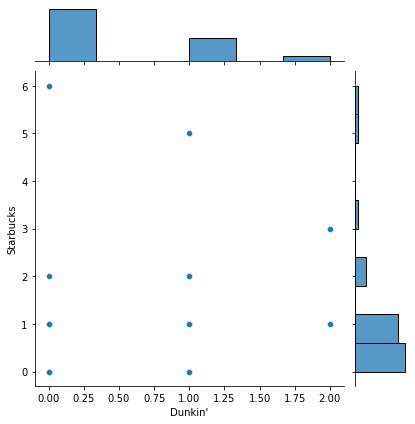

In [42]:
plot = sns.jointplot(x="Dunkin'",y='Starbucks', data=wszips3)

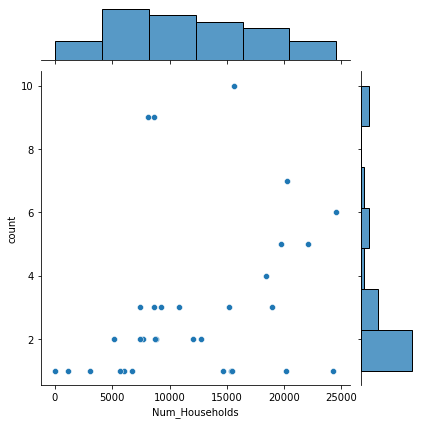

In [43]:
plot = sns.jointplot(x='Num_Households',y='count', data=wszips3)

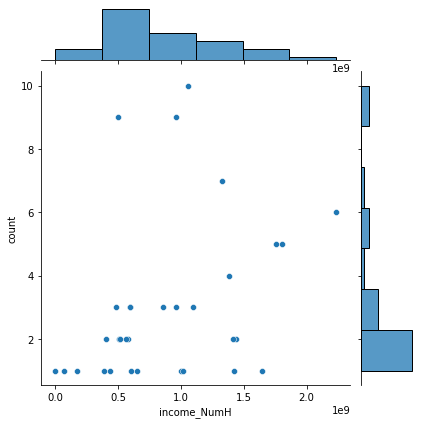

In [44]:
plot = sns.jointplot(x='income_NumH',y='count', data=wszips3)

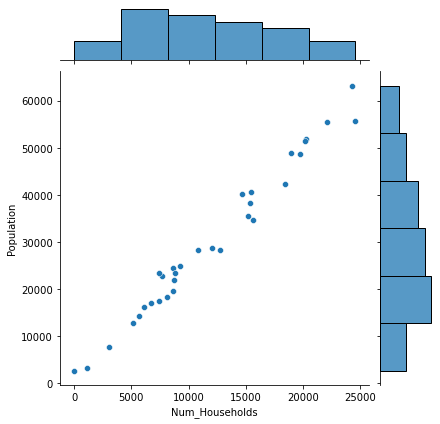

In [45]:
plot = sns.jointplot(x='Num_Households',y='Population', data=wszips3)

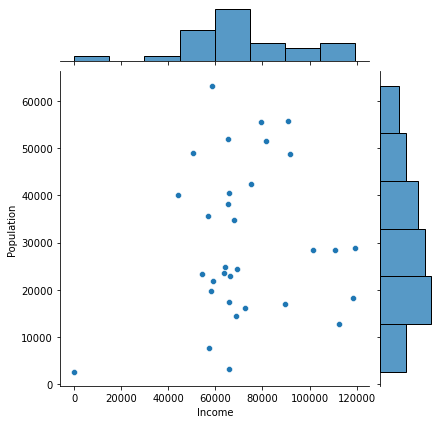

In [46]:
plot = sns.jointplot(x='Income',y='Population', data=wszips3)

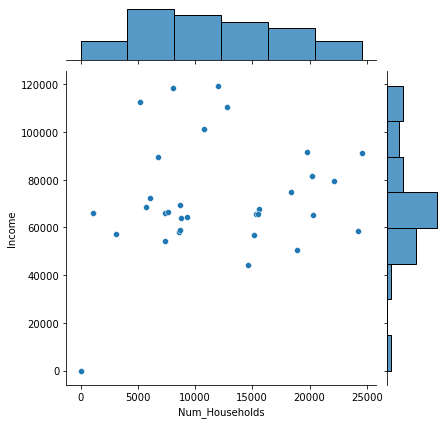

In [47]:
plot = sns.jointplot(x='Num_Households',y='Income', data=wszips3)

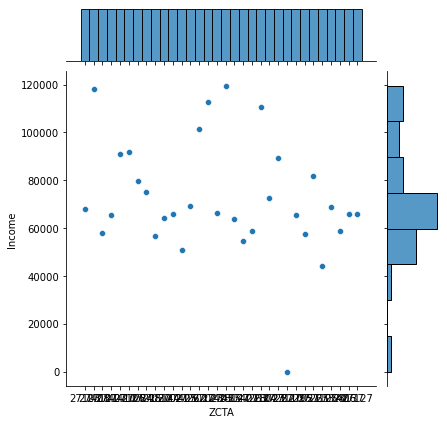

In [48]:
plot = sns.jointplot(x='ZCTA',y='Income', data=wszips3)

In [49]:
wszips3.sort_values(by = 'income_NumH', ascending = False).head()

,ZCTA5CE10,count,Dunkin',Other,Starbucks,ZCTA,Num_Households,Income,Population,income_NumH
4,27410,6,0,0,6,27410,24560,91063,55707,2236507280
5,27106,5,2,2,1,27106,19745,91605,48709,1808740725
6,27284,5,0,3,2,27284,22113,79553,55489,1759155489
26,27265,1,0,0,1,27265,20195,81695,51477,1649830525
16,27455,2,0,1,1,27455,12018,119493,28791,1436066874


In [50]:
income_map = folium.Map(location=[36.11,-80.23], zoom_start=10)

income_map.choropleth(
    geo_data=nc_zips,
    key_on='feature.properties.ZCTA5CE10',
    data=wszips3,
    columns=['ZCTA5CE10','Income'],
    fill_color='YlOrRd',
     nan_fill_color='black',
     nan_fill_opacity=0.1,
     line_opacity=0.9,
    fill_opacity=0.5,
    legend_name="Winston Salem NC Household Income per ZCTA"
)


# add venues to map
income_map.add_child(venues)
income_map

C:\ProgramData\Anaconda3\lib\site-packages\folium\folium.py:413: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [51]:
pop_map = folium.Map(location=[36.11,-80.23], zoom_start=10)

pop_map.choropleth(
    geo_data=nc_zips,
    key_on='feature.properties.ZCTA5CE10',
    data=wszips3,
    columns=['ZCTA5CE10','Population'],
    fill_color='YlOrRd',
     nan_fill_color='black',
     nan_fill_opacity=0.1,
     line_opacity=0.9,
    fill_opacity=0.5,
    legend_name="Winston Salem NC Population per ZCTA"
)

# add venues to map
pop_map.add_child(venues)
pop_map

In [52]:
inc_house_map = folium.Map(location=[36.11,-80.23], zoom_start=10)

inc_house_map.choropleth(
    geo_data=nc_zips,
    key_on='feature.properties.ZCTA5CE10',
    data=wszips3,
    columns=['ZCTA5CE10','income_NumH'],
    fill_color='YlOrRd',
     nan_fill_color='black',
     nan_fill_opacity=0.1,
     line_opacity=0.9,
    fill_opacity=0.5,
    legend_name="Winston Salem NC Mean Income per Household X No. Households per ZCTA"
)
# add a label: https://towardsdatascience.com/a-step-by-step-guide-to-interactive-choropleth-map-in-python-681f6bd853ce
# choropleth.geojson.add_child(
#     folium.features.GeoJsonTooltip(['ZCTA5CE10'], labels=False))

# add venues to map
inc_house_map.add_child(venues)
inc_house_map

In [53]:
ws = folium.Map(location=[36.11,-80.23], zoom_start=10, tiles='cartodbpositron')
choropleth = folium.Choropleth(
    geo_data=nc_zips,
    data=wszips3,
    columns=['ZCTA5CE10','income_NumH'],
    key_on='feature.properties.ZCTA5CE10',
    fill_color='YlOrRd',
    nan_fill_color='black',
    nan_fill_opacity=0.1,
    fill_opacity=0.5, 
    line_opacity=0.9,
    legend_name='Winston Salem NC Mean Income per Household X No. Households per ZCTA',
).add_to(ws)
choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['ZCTA5CE10'], labels=False))
ws



# add venues to map
ws.add_child(venues)
ws

In [54]:
wszips3.sort_values(by = 'ZCTA5CE10', ascending = False).head()

,ZCTA5CE10,count,Dunkin',Other,Starbucks,ZCTA,Num_Households,Income,Population,income_NumH
17,28147,2,1,0,1,28147,8814,63834,23495,562632876
9,28144,3,1,1,1,28144,9276,64204,24858,595556304
30,28137,1,0,1,0,28137,1112,65863,3181,73239656
21,28023,1,0,1,0,28023,6062,72385,16129,438797870
16,27455,2,0,1,1,27455,12018,119493,28791,1436066874
